# Laboratorio 2 – Aprendizaje de máquina  
## Complejidad y búsqueda de hiperparámetros – AlpesHearth  

### Integrantes:
1. Juan Sebastian Rodriguez Torres - 202214617 - js.rodriguezt1@uniandes.edu.co
2. Luis Felipe Sales Galviz - 202211531 - l.sales@uniandes.edu.co


## Carga de datos:

En esta sección vamos a cargar los datos para dejarlo con las modificaciones iniciales realizadas previas al modelado en el LAB 1:
Las columnas irrelevantes quedan eliminadas, los registros duplicados, las filas sin variable objetuvo y los "CVD Risk Score" menores a 0 y mayores a 100 tambien. Dado que el enfoque ahora está en modelado y validación, no se repetirá el proceso de exploración ni limpieza profunda que se hizo para cada modelo del lab 1.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df_real = pd.read_csv("./data/Datos Lab 1.csv")
df = df_real.copy()

In [25]:
target = "CVD Risk Score"
cantNulos = df[target].isnull().sum()
df = df.dropna(subset=[target])
print(f"Registros con Risk Score nulo eliminados: {cantNulos}")

antes = df.shape[0]
df["Date of Service"] = pd.to_datetime(df["Date of Service"], errors="coerce")
df = df.sort_values(["Patient ID", "Date of Service"])
df = df.drop_duplicates(subset="Patient ID", keep="last")
desp = df.shape[0]
print(f"Duplicados eliminados: {antes - desp} (quedan {desp})")


df = df.drop(["Patient ID", "Date of Service", 
        "Blood Pressure (mmHg)", "Blood Pressure Category", 
        "CVD Risk Level"], axis =1)

df["CVD Risk Score"] = df["CVD Risk Score"].clip(0, 100)

df.head()

Registros con Risk Score nulo eliminados: 29
Duplicados eliminados: 261 (quedan 1349)


,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score
675,F,52.0,109.700,1.780,34.600,104.400,197.0,0.915,99.0,N,Y,High,N,178.000,0.587,103.0,99.0,NaN,18.010
1369,F,NaN,104.469,1.995,25.390,86.894,NaN,82.000,175.0,N,N,Low,Y,199.458,0.436,164.0,90.0,147.0,18.458
774,M,58.0,NaN,1.870,33.800,99.600,106.0,6.809,115.0,Y,Y,Low,N,187.000,0.533,NaN,91.0,33.0,16.530
1044,F,52.0,107.800,1.780,34.000,103.500,179.0,73.000,132.0,N,N,Low,Y,178.000,0.581,111.0,69.0,76.0,15.930
1290,M,57.0,116.772,1.569,34.126,90.737,254.0,60.000,177.0,N,N,Low,Y,156.854,0.578,117.0,116.0,164.0,17.755


## Detección y tratamiento de outliers:

A continuación, se muestra el proceso de detección y tratamiento de outliers utilizando el método del rango intercuartílico (IQR) para cada una de las variables numéricas. Se identifican los valores atípicos y se eliminan del conjunto de datos para mejorar la calidad del modelo.



◉ HISTOGRAMA PARA VER APROXIMADAMENTE VALORES ATÍPICOS



<Axes: >

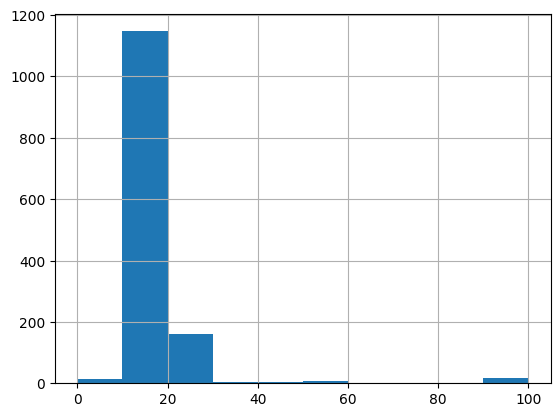

In [26]:
print("\n\n◉ HISTOGRAMA PARA VER APROXIMADAMENTE VALORES ATÍPICOS\n")
df["CVD Risk Score"].hist()

Con la anterior gráfica se pueden identificar los outliers de la variable CVD Risk Score, que es la variable objetivo. Se pueden observar algunos puntos muy alejados del resto de los datos, lo que indica que son valores atípicos. Para tratarlos, se puede utilizar el método del rango intercuartílico (IQR) para identificar y eliminar estos outliers del conjunto de datos. Esto ayudará a mejorar la calidad del modelo y a obtener resultados más precisos.

In [27]:
Q1 = df["CVD Risk Score"].quantile(0.05)
Q3 = df["CVD Risk Score"].quantile(0.95)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df["CVD Risk Score"] >= lower) & (df["CVD Risk Score"] <= upper)]

## División del conjunto de datos

Para evaluar adecuadamente la capacidad de generalización de los modelos, el dataset será dividido en Conjunto de entrenamiento (75%) y Conjunto de prueba (25%)

El conjunto de entrenamiento se utilizará para el ajuste de modelos y la búsqueda de hiperparámetros.

El conjunto de prueba se utilizará al final para evaluar el desempeño del modelo que seleccionems.

In [28]:
target = "CVD Risk Score"
X = df.drop(columns=[target])
y = df[target]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Asi queda el tamaño de cada conjunto:

In [30]:
X_train.shape, y_train.shape

((990, 18), (990,))

In [31]:
X_test.shape, y_test.shape

((330, 18), (330,))

## 1. Modelo de regresión polinomial
La regresión polinomial permite modelar relaciones no lineales mediante la expansión de las variables originales en términos de mayor grado.

1. Preprocesamiento
2. Generación de características polinomiales
3. Modelo de regresión lineal

Con GridSearchCV para explorar los diferentes grados del polinomio y distintas estrategias de escalamiento

El desempeño será evaluado mediante los mismos parametros: RMSE, MAE y R²

## Pipeline

El pipeline es una herramienta que permite encadenar varias etapas de procesamiento y modelado en un flujo de trabajo coherente. En este caso, se utilizará para combinar el preprocesamiento de datos, la generación de características polinomiales y el modelo de regresión lineal en un solo objeto que se puede ajustar y evaluar de manera eficiente. Asi se aplicaran las mismas transformaciones tanto al conjunto de entrenamiento como al de prueba, evitando fugas de datos y asegurando una evaluación justa del modelo.

Ahora procedemos a eliminar las columnas irrelevantes, en este caso Patient ID, Date of Service, Blood Pressure, y Height (m), ya que tenemos una columna ya llamada Height (cm), por lo que es redundante, estas columnas  no aportan información relevante para el modelo de regresión polinomial y podrían introducir ruido en el proceso de modelado.

In [32]:
columnas_drop = ["Patient ID", "Date of Service", "Blood Pressure (mmHg)",
                 "Height (m)"]

def drop(df):
    return df.drop(columns=columnas_drop, errors="ignore")

dropper = FunctionTransformer(drop, validate=False)

Podemos ver que en el laboratorio anterior se observaron datos estadisticos del dataframe encontramos algunos datos que no son validos. Por ejemplo, el colesterol total tiene un min = - 1.256, pasaremos este valor a positivo con valor absoluto, por otra parte, el LDL estimado tiene min= -92.055. Haremos lo mismo, pondremos el absoluto de estos valores. Luego los utilizaremos en el pipeline.

In [33]:
def limpiar_colesterol(df):
    df["Total Cholesterol (mg/dL)"] = df["Total Cholesterol (mg/dL)"].abs()
    return df

def limpiar_ldl(df):
    df["Estimated LDL (mg/dL)"] = df["Estimated LDL (mg/dL)"].abs()
    return df

limpieza_colesterol = FunctionTransformer(limpiar_colesterol)
limpieza_ldl = FunctionTransformer(limpiar_ldl)


Ahora, podemos separar la columna blood pressure y reemplazar los datos de Systolic y Diastolic en las columnas correspondientes, donde estas esten vacias, esto con el fin de tener una mejor interpretación de los datos y evitar confusiones al momento de modelar. 

In [34]:
def separar_presion(df):
    df = df.copy()
    if "Blood Pressure (mmHg)" in df.columns:
        bp = df["Blood Pressure (mmHg)"].str.extract(r'(\d+)/(\d+)')
        
        df["Systolic BP"] = bp[0].astype(float)
        df["Diastolic BP"] = bp[1].astype(float)
    return df

separacion_presion = FunctionTransformer(separar_presion)


## Imputaciones con variables dependientes

En la siguiente gráfica se muestra un heatmap para visualizar la correlación entre las variables numéricas del dataset. Esto nos permite identificar qué variables tienen una relación más fuerte con la variable objetivo (CVD Risk Score) y cuáles podrían ser útiles para la imputación de valores faltantes en otras variables. Al observar el heatmap, podemos tomar decisiones informadas sobre cómo manejar los datos faltantes y mejorar la calidad del modelo.



◉ HEATMAP PARA VER CORRELACIÓN ENTRE VARIABLES:



<Axes: >

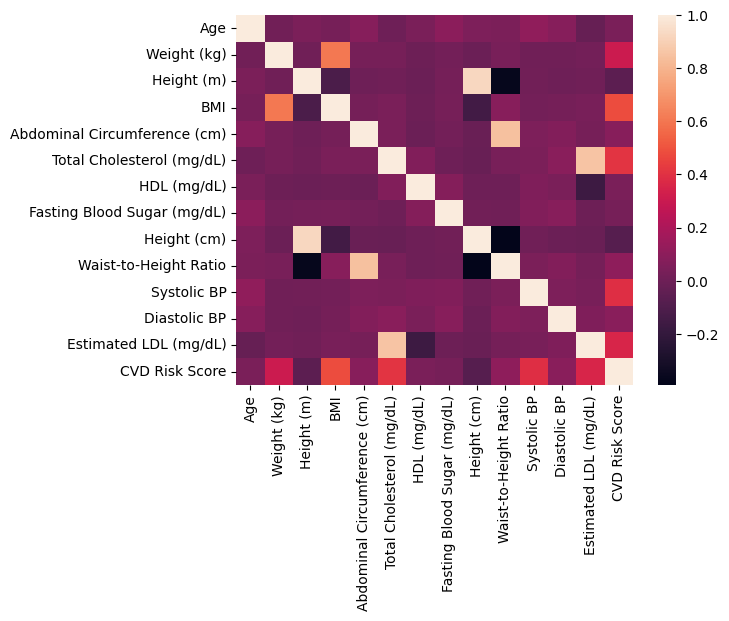

In [35]:
print("\n\n◉ HEATMAP PARA VER CORRELACIÓN ENTRE VARIABLES:\n")
sns.heatmap(df.corr(numeric_only=True))

Como podemos ver en la anterior gráfica, la variable Abdominal Circumference (cm) tiene una correlación importante con la variable Waist-toHeight Ratio, por lo que se puede utilizar esta última para imputar los valores faltantes de la primera. Lo mismo ocurre con Total Cholesterol (mg/dL) y Estimated LDL (mg/dL), que tienen una correlación significativa, por lo que se puede utilizar la variable Estimated LDL para imputar los valores faltantes de Total Cholesterol. Estas imputaciones basadas en variables dependientes pueden ayudar a mejorar la calidad del dataset y, por ende, el desempeño del modelo de regresión polinomial.

A continuación vamos a ver las columnas con valores nulos, para luego decidir cómo imputarlos. 

In [ ]:
df.isna().sum().sort_values(ascending=False)

HDL (mg/dL)                     65
Waist-to-Height Ratio           62
Weight (kg)                     61
Diastolic BP                    58
Age                             57
Height (cm)                     56
Total Cholesterol (mg/dL)       56
Systolic BP                     53
Estimated LDL (mg/dL)           47
Height (m)                      46
Abdominal Circumference (cm)    46
Fasting Blood Sugar (mg/dL)     46
BMI                             42
Sex                              0
Smoking Status                   0
Diabetes Status                  0
Family History of CVD            0
Physical Activity Level          0
CVD Risk Score                   0
dtype: int64

Por el heatmap notamos que la mayoria de los datos no están correlacionados excepto por **Abdominal Circunference con Waist-to-Height Ratio** y **Total Cholesterol con Estimated LDL (mg/dL)**. Por lo que imputaremos los datos nulos de estas variables usando el método de varialbes correlacionadas.

In [ ]:
def imputar_total_cholesterol_con_ldl(df):
    y = "Total Cholesterol (mg/dL)"
    x = "Estimated LDL (mg/dL)"
    
    k = (df[y] / df[x]).dropna().median()
    df = df.fillna({y: k * df[x]})
    df[y] = df[y].round()
    return df

chol_imputer = FunctionTransformer(imputar_total_cholesterol_con_ldl, validate=False)

In [ ]:
def imputar_waist_to_height_ratio_con_circ(df):
    ratio = "Waist-to_Height Ratio"
    circ = "Abdominal Circumference (cm)"
    k = (df[ratio] / df[circ]).dropna().median()
    df = df.fillna({ratio: df[circ] * k})
    df[ratio] = df[ratio].round()
    return df

waist_height_imputer = FunctionTransformer(imputar_waist_to_height_ratio_con_circ, validate=False)



Ahora procedemos a separar las variables numéricas, ordinales y categóricas con el fin de aplicar las transformaciones necesarias para cada tipo de variable. 

In [ ]:
numeric_features = [
    "Age", "Weight (kg)", "BMI", "Height (cm)",
    "Abdominal Circumference (cm)", "Total Cholesterol (mg/dL)",
    "HDL (mg/dL)", "Fasting Blood Sugar (mg/dL)",
    "Waist-to-Height Ratio", "Systolic BP", "Diastolic BP",
    "Estimated LDL (mg/dL)",
]


ordinal_features = ["Physical Activity Level", "Blood Pressure Category", 
                    "CVD Risk Level"]

categorical_features = [
    "Sex", "Smoking Status", "Diabetes Status",
    "Family History of CVD",
]

Ya que tenemos separadas las variables numéricas, ordinales y categóricas, podemos aplicar las transformaciones necesarias para cada tipo de variable. Vamos a solucionar problemas de completitud imputando por la media, escalaremos las variables numéricas con StandardScaler, y aplicaremos PolynomialFeatures() a las variables numéricas.

In [ ]:
numeric_transformer_polinomial = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("polynomial", PolynomialFeatures(degree=2)),
    ]
)

Hacemos las mismas transformaciones para las variables categóricas y ordinales que se hicieron en el laboratorio anterior.

In [ ]:
categorical_transformer = Pipeline(
    steps= [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]
)

In [ ]:
ordinal_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            OrdinalEncoder(
                categories= [
                    ["Low, Moderate, High"],
                    ["Normal", "Elevated", "Hypertension Stage 1", "Hypertension Stage 2"],
                    ["Low", "Moderate", "High"]
                ],
                handle_unknown="use_encoded_value",
                unknown_value= np.nan,
            ),
        ),
        ("imputer_after", SimpleImputer(strategy="most_frequent")),
    ]
)

Ahora con ColumnTransformer, combinamos las transformaciones para las variables numéricas, ordinales y categóricas en un solo objeto que se puede aplicar a los datos de entrenamiento y prueba. Esto nos permite asegurarnos de que todas las transformaciones se apliquen de manera consistente y eficiente durante el proceso de modelado.

In [ ]:
preprocessor = ColumnTransformer(
    transformers= {
        ("num_scaled", numeric_transformer_polinomial, numeric_features),
        ("ord", ordinal_transformer, ordinal_features),
        ("cat", categorical_transformer, categorical_features)
    }
)

Finalmente, definimos el pipeline completo que incluye el preprocesamiento de datos y el modelo de regresión lineal. Esto nos permitirá ajustar el modelo de manera eficiente y evaluar su desempeño utilizando las métricas RMSE, MAE y R².

In [ ]:
pipeline_regresion_polinomial = Pipeline(
    steps=[
        ("separacion_presion", separacion_presion),
        ("dropper", dropper),
        ("limpiar_colesterol", limpieza_colesterol),
        ("limpiar_ldl", limpieza_ldl),
        ("imputacion_cholesterol", chol_imputer),
        ("imputacion_whtr", waist_height_imputer),
        ("preprocessor", preprocessor),
        ("modelo", LinearRegression()),
    ]
)

Visualizamos el pipeline de la regresión polinomial.

In [ ]:
from sklearn import set_config
set_config(display="diagram")

pipeline_regresion_polinomial

## 2. Curvas de validación
Para analizar el impacto de la complejidad, se generarán curvas de validación que muestren cómo varía el error en función del grado del polinomio.
Se grafica el rrror promedio en validación cruzada y la desviación estándar del error
El objetivo es identificarel puunto de mínima generalización, la evidencia de sobreajuste y la relación entre complejidad y estabilidad,


## 3. Modelos de regresión regularizados

La regularización son para controlar la magnitud de los coeficientes y reducir el sobreajuste.
Se usaran las tecnicas Ridge y Lasso

Se utilizará GridSearchCV para buscar diferentes valores del parámetro de penalización y estrategias de escalamiento

El análisis incluirá:
- Comparación de métricas
- Evaluación de estabilidad
- Análisis de magnitud de coeficientes
- Identificación de variables eliminadas por Lasso

## 4. Modelo polinomial regularizado

En esta sección se hara la generación de características polinomiales y la regularización.
Se explorarán simultáneamente los grados del polinomio, los parámetro de penalización y una estrategia para escalar.
El objetivo es evaluar si la regularización permite controlar el sobreajuste generado por el aumento en la complejidad.

## 5. Comparación y selección del mejor modelo

Haremos una tabla comparando: RMSE, MAE y R² y basados en los datos explicaremos cual es el mejor modelo.

## 6. Construcción de ntervalos de confianza


## 7. Análisis de resultados

### Análisis cuantitativo:

- ¿Cuál modelo obtuvo el mejor desempeño en test?
- ¿Coincide con el mejor promedio en validación cruzada?
- ¿El modelo con mejor promedio es necesariamente el más adecuado?
- ¿Cómo cambia el error con la complejidad?
- ¿Cómo afecta la regularización la estabilidad de los coeficientes?
- ¿Los intervalos de confianza sugieren estabilidad o alta variabilidad?

### Análisis cualitativo:

- Variables seleccionadas por Lasso.
- Interpretación práctica de los coeficientes.
- Diferencias entre precisión e interpretabilidad.
- Implicaciones estratégicas para AlpesHearth.
- Si mayor complejidad implica mayor valor organizacional.

## 8. Reflexión conceptual

## 9. Uso de IA generativa

Durante el desarrollo del laboratorio usamos modelos de IA generativa como herramienta de apoyo conceptual y para la estructuración del notebook.

Las decisiones de modificacion de datos y construccion de modelps, la interpretación de los resultados y los analisis fueron realizadas por el equipo, unicamente usando inteligencia artificial para confirmar conceptos o estructurar adecuadamente elementos repetitivos en los bloques de codigo para ahorrar tiempo.